# Setup

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import sys

# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS-487-Project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
sys.path.append(GOOGLE_DRIVE_PATH)

['reuters_headlines.pickle', 'wiki_sentences.pickle', 'abcnews-date-text.csv', 'Short-Text-Corpus-For-Humor-Detection-master.zip', '.DS_Store', 'wiki.csv', 'reuters.csv', 'Short-Text-Corpus-For-Humor-Detection-master', '__pycache__', '.idea', '.git', '.ipynb_checkpoints', 'vectors.kv.vectors.npy', 'vectors.kv', 'dev.csv', 'gold-test-27446.csv', 'train.csv', 'run_main.ipynb', 'copy transformer_main.ipynb（副本）', 'transformer_main with data.ipynb', 'copy transformer_main.ipynb', 'translated_train.csv', 'data_augementation.py', 'main.py', 'model.py', 'naive_bayes.py', 'pickle_to_csv.py', 'train.py', 'transformer.py', 'README.md', 'back_trarnslate_main.ipynb', 'data_processor.py', 'main.ipynb']


In [8]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
# install required packages
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
 %load_ext autoreload
%autoreload 2

import os
import json

import numpy as np
import gensim.downloader
from torch.utils.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BERT Overfit

In [ ]:
# CUDA_LAUNCH_BLOCKING = "1"

!pip3 install transformers
!pip3 install datasets
!{sys.executable} -m pip install sentencepiece
import pandas as pd
from transformer import train
from datasets import load_dataset
from transformers import AutoTokenizer

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments
from transformers import DistilBertTokenizerFast
from transformer import TransformerDataset
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import random


     |████████████████████████████████| 4.0 MB 12.3 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 6.5 MB 37.7 MB/s 
     |████████████████████████████████| 596 kB 16.4 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pyparsing.py", line 4254, in parseImpl
    ret = e._parse(instring, loc, doActions)
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pyparsin

ModuleNotFoundError: ignored

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/train.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

# dataset = [{
#     "label": l,
#     "text": t
# } for l, t in zip(label, data_text)]

# print(dataset[100])

# dataset = load_dataset("lm233/humor_train")
# print(dataset[100])
# train(dataset)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

train_dataset = TransformerDataset(train_encodings, label)
small_train_data = torch.utils.data.Subset(train_dataset, random.sample(range(0, len(train_dataset)), 5000))
# print(len(small_train_data))
# print(train_dataset[0])
small_train_dataloader = DataLoader(small_train_data, shuffle=True, batch_size=16)





In [ ]:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-6)

num_epochs = 50      # 50
num_training_steps = num_epochs * len(small_train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
model.to(device)

num_itr = 0
progress_bar = tqdm(range(num_training_steps))
val_loss = []
train_loss = []
train_loss_ind = []
val_loss_ind = []

model.train()
for epoch in range(num_epochs):
    for batch in small_train_dataloader:
        num_itr += 1
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        train_loss.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss_ind.append(num_itr)

    metric = load_metric("accuracy")
    model.eval()
    for batch in small_train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    val_loss_ind.append(num_itr)
    val_loss.append(outputs.loss.item())
    print("validation", metric.compute(), "loss", outputs.loss.item())


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/15650 [00:00<?, ?it/s]

validation {'accuracy': 0.9208} loss 0.6488897800445557


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

"""Plot training loss and validation loss."""
print(train_loss)
print(train_loss_ind)
print(val_loss_ind)
print(val_loss)

plt.plot(train_loss_ind, train_loss, label='Training loss')
plt.plot(val_loss_ind, val_loss, label='Validation loss')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

# Transformer Train with 2 FC layers

this is training a model: BERT + 2 FC layers

In [11]:
!pip3 install transformers
!pip3 install datasets
!{sys.executable} -m pip install sentencepiece
import pandas as pd

# from transformer import train
from datasets import load_dataset
from transformers import AutoTokenizer

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments
from transformers import DistilBertTokenizerFast
from transformer import TransformerDataset
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import random

load train and dev data

In [23]:
df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/train.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

train_dataset = TransformerDataset(train_encodings, label)
# small_train_data = torch.utils.data.Subset(train_dataset, random.sample(range(0, len(train_dataset)), 500))
# print(train_dataset[0])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/dev.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
dev_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

dev_dataset = TransformerDataset(dev_encodings, label)
# print(train_dataset[0])
dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=16)

train the model

In [28]:
from transformer import CustomBERTModel
from train import get_optimizer, train_model, plot_loss, get_performance, get_hyper_parameters, get_loss_fn, calculate_loss
import torch 

model = CustomBERTModel().to(device)
# model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3).to(device)

# optim = get_optimizer(model, lr=1e-4, weight_decay=1e-5)
# # optimizer = AdamW(model.parameters(), lr=5e-5)

# scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=1.0,
#                                               end_factor=0, total_iters=40)
# net, stats = train_model(model, train_dataloader, dev_dataloader, optim, scheduler,
#                             num_epoch=40, patience=10, collect_cycle=500,
#                             device=device, verbose=True)

# plot_loss(stats)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 30      # 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)

loss_fn = get_loss_fn()


model.to(device)

num_itr = 0
progress_bar = tqdm(range(num_training_steps))
val_loss = []
train_loss = []
train_loss_ind = []
val_loss_ind = []

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        num_itr += 1
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        # loss = outputs.loss
        loss = calculate_loss(outputs, torch.nn.functional.one_hot(batch["labels"], num_classes=3), loss_fn)        
        loss.backward()
        train_loss.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss_ind.append(num_itr)

    metric = load_metric("accuracy")
    model.eval()
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = calculate_loss(outputs, torch.nn.functional.one_hot(batch["labels"], num_classes=3), loss_fn)
        logits = outputs
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    val_loss_ind.append(num_itr)
    val_loss.append(loss.item())
    print("validation", metric.compute(), "loss", loss.item())



KeyboardInterrupt: ignored

test the model

In [ ]:
import sklearn


df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/gold-test-27446.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

y_true = []
y_pred = []


test_dataset = TransformerDataset(test_encodings, label)
# print(train_dataset[0])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

metric = load_metric("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss = calculate_loss(outputs, torch.nn.functional.one_hot(batch["labels"], num_classes=3), loss_fn)

    logits = outputs
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    y_true.append((batch["labels"]).cpu())
    y_pred.append(predictions.cpu())


y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
mac_f1 = sklearn.metrics.f1_score(y_pred, y_true, average='macro')
mic_f1 = sklearn.metrics.f1_score(y_pred, y_true, average='micro')


val_loss_ind.append(num_itr)
val_loss.append(outputs.loss.item())
print("test", metric.compute(), "loss", outputs.loss.item(), "mac_f1", mac_f1, "mic_f1", mic_f1)



# from train import evaluate


# df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/gold-test-27446.csv", header=0,
#                   names=("id", "text", "is_humor", "humor_rating", "humor_controversy", "offense_rating"))

# data_text, label = df["text"].tolist(), df["is_humor"].tolist()

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# # tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# test_encodings = tokenizer(data_text, truncation=True, padding=True)
# # print(train_encodings)

# test_dataset = TransformerDataset(test_encodings, label)
# # print(train_dataset[0])
# test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=16)


# loss_fn = get_loss_fn()
# accuracy, loss, mac_f1, mic_f1 = evaluate(model, loss_fn, test_dataloader, device)
# print("test acc, loss, mac_f1, mic_f1: ", accuracy, loss, mac_f1, mic_f1)

# Transformer Train

this is training a BERT model

In [ ]:
!pip3 install transformers
!pip3 install datasets
!{sys.executable} -m pip install sentencepiece
import pandas as pd

# from transformer import train
from datasets import load_dataset
from transformers import AutoTokenizer

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
from datasets import load_metric
from transformers import TrainingArguments
from transformers import DistilBertTokenizerFast
from transformer import TransformerDataset
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import random

load train and dev data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/train.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

train_dataset = TransformerDataset(train_encodings, label)
# small_train_data = torch.utils.data.Subset(train_dataset, random.sample(range(0, len(train_dataset)), 500))
# print(train_dataset[0])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/dev.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
dev_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

dev_dataset = TransformerDataset(dev_encodings, label)
# print(train_dataset[0])
dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=16)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

train the model

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-7)

num_epochs = 30      # 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
model.to(device)

num_itr = 0
progress_bar = tqdm(range(num_training_steps))
val_loss = []
train_loss = []
train_loss_ind = []
val_loss_ind = []

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        num_itr += 1
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        train_loss.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss_ind.append(num_itr)

    metric = load_metric("accuracy")
    model.eval()
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    val_loss_ind.append(num_itr)
    val_loss.append(outputs.loss.item())
    print("validation", metric.compute(), "loss", outputs.loss.item())


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/22500 [00:00<?, ?it/s]

validation {'accuracy': 0.72} loss 0.6923525333404541
validation {'accuracy': 0.834} loss 0.4714084565639496
validation {'accuracy': 0.874} loss 0.5183125138282776
validation {'accuracy': 0.88} loss 0.4374467134475708
validation {'accuracy': 0.888} loss 0.33778640627861023
validation {'accuracy': 0.892} loss 0.6585562825202942
validation {'accuracy': 0.896} loss 0.06431605666875839
validation {'accuracy': 0.894} loss 0.08296067267656326
validation {'accuracy': 0.896} loss 0.15888649225234985
validation {'accuracy': 0.8993333333333333} loss 0.35886669158935547
validation {'accuracy': 0.9006666666666666} loss 0.24093973636627197
validation {'accuracy': 0.8986666666666666} loss 0.4560224115848541
validation {'accuracy': 0.9026666666666666} loss 0.029270881786942482
validation {'accuracy': 0.9006666666666666} loss 0.08754187822341919
validation {'accuracy': 0.9026666666666666} loss 0.3192248046398163
validation {'accuracy': 0.902} loss 0.11445138603448868
validation {'accuracy': 0.9} loss 

plot loss curves

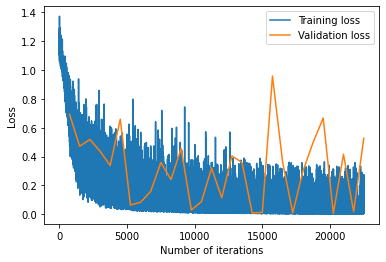

In [ ]:
import matplotlib.pyplot as plt

"""Plot training loss and validation loss"""
# print(train_loss)
# print(train_loss_ind)
# print(val_loss_ind)
# print(val_loss)

plt.plot(train_loss_ind, train_loss, label='Training loss')
plt.plot(val_loss_ind, val_loss, label='Validation loss')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

test the model

In [ ]:
import sklearn


df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/gold-test-27446.csv", header=0,
                  names=("id", "text", "is_humor"))

data_text, label = df["text"].tolist(), df["is_humor"].tolist()

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_encodings = tokenizer(data_text, truncation=True, padding=True)
# print(train_encodings)

y_true = []
y_pred = []


test_dataset = TransformerDataset(test_encodings, label)
# print(train_dataset[0])
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16)

metric = load_metric("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    y_true.append((batch["labels"]).cpu())
    y_pred.append(predictions.cpu())

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred)
mac_f1 = sklearn.metrics.f1_score(y_pred, y_true, average='macro')
mic_f1 = sklearn.metrics.f1_score(y_pred, y_true, average='micro')


val_loss_ind.append(num_itr)
val_loss.append(outputs.loss.item())
print("test", metric.compute(), "loss", outputs.loss.item(), "mac_f1", mac_f1, "mic_f1", mic_f1)

test {'accuracy': 0.9046666666666666} loss 0.001878762966953218 mac_f1 0.8971885020935803 mic_f1 0.9046666666666666


write texts, predictions, and true labels to a csv file

In [ ]:
import csv


y_pred = ["predictions"] + y_pred.tolist()
data_text = ["texts"] + data_text
label = ["labels"] + (y_true).tolist()


mylist = zip(data_text, label, y_pred)
with open('preds.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for l in mylist:
        wr.writerow(l)




# model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to("cuda:0")
# optimizer = AdamW(model.parameters(), lr=5e-5)

# num_epochs = 50
# num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
# )

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# # model.to(device)
# model.cuda()


# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     metric = load_metric("accuracy")
#     model.eval()
#     for batch in dev_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         with torch.no_grad():
#             outputs = model(**batch)

#         logits = outputs.logits
#         predictions = torch.argmax(logits, dim=-1)
#         metric.add_batch(predictions=predictions, references=batch["labels"])

#     print(metric.compute())


In [ ]:
# !pip3 install transformers
# !{sys.executable} -m pip install sentencepiece
from data_augementation import back_translate
from transformers import MarianMTModel, MarianTokenizer
import csv
import pandas as pd
    
df = pd.read_csv("/content/drive/MyDrive/EECS-487-Project/train.csv", header=0,
                  names=("id", "text", "is_humor"))
# x = df["text"].tolist()
data_text, label = df["text"].tolist(), df["is_humor"].tolist()

# print(data_text)
# back_texts = back_translate(data_text, "en", "fr")
# print(back_texts)
# back_texts = ["text"] + back_texts
# label = ["is_humor"] + label
# rows = zip(back_texts, label)
count = 0
with open("/content/drive/MyDrive/EECS-487-Project/translated_train.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["text", "is_humor"])
    for d, l in zip(data_text, label):
        if count % 30 == 0:
          b = back_translate([d], "en", "fr")
          writer.writerow([b[0], l])
        count += 1
        print(count)



ModuleNotFoundError: ignored

# Load Data

load train, dev, test

In [ ]:

import itertools
from tqdm.notebook import tqdm
from train import get_optimizer, train_model, plot_loss, get_performance, get_hyper_parameters, get_loss_fn
from model import Model
from naive_bayes import NaiveBayes, evaluate
from data_processor import basic_collate_fn, HumorDataset, load_data, load_data_nb
import os
import torch
from torch.utils.data import DataLoader
# !pip3 install sentencepiece
# !{sys.executable} -m pip install sentencepiece
# from transformers import MarianMTModel, MarianTokenizer

x_train, y_train = load_data("/content/drive/My Drive/EECS-487-Project/train.csv")
x_dev, y_dev = load_data("/content/drive/My Drive/EECS-487-Project/dev.csv")
x_test, y_test = load_data("/content/drive/My Drive/EECS-487-Project/gold-test-27446.csv")
train_data = HumorDataset(x_train, y_train)
dev_data = HumorDataset(x_dev, y_dev)
test_data = HumorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=False)


# Overfit LSTM

overfit LSTM model

In [ ]:
from main import overfit
overfit(train_data)

# LSTM hyperparameter search

In [ ]:
from main import search_param_basic
net = search_param_basic(train_loader, dev_loader)

# Train LSTM

train LSTM model

In [ ]:
net = Model(256).to(device)
optim = get_optimizer(net, lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=1.0,
                                              end_factor=0, total_iters=40)
model, stats = train_model(net, train_loader, dev_loader, optim, scheduler,
                            num_epoch=40, patience=10, collect_cycle=500,
                            device=device, verbose=True)

------------------------ Start Training ------------------------


AttributeError: ignored

plot loss curves

In [ ]:
plot_loss(stats)

print performance

In [ ]:
from train import evaluate
loss_fn = get_loss_fn()
accuracy, loss, mac_f1, mic_f1 = evaluate(model, loss_fn, test_loader, device)
print("test acc, loss, mac_f1, mic_f1: ", accuracy, loss, mac_f1, mic_f1)